# GA Placement and GA Backup Allocation (GAPA-GABA)

In [2]:
#libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pygad

# Dataset

In [3]:
# number of categories 
M = 3
# w_i for each node in category c_i
w = [5, 4, 1]
# price of each active node in category c_i  
pa = [25, 20, 5]
# price of each standby node in category c_i 
ps = [2.5, 2, 0.5]
# failure rate of each active node in category c_i 
fa = [0.008, 0.01, 0.04]
# failure rate of each standby node in category c_i 
fs = [0.0008, 0.001, 0.004]

# total number of nodes
N = 800
# M_i for each category c_i
Mi = [200, 300, 300] 

# parameter of SFC
K = 10
Nk = [5, 5, 5, 5, 3, 2, 5, 3, 2, 5]
Lk = [[10, 20, 5, 6, 9], [1, 1, 1, 1, 1], [20, 40, 50, 45, 45], [10, 20, 25, 25, 20], [3, 4, 8], [2, 2], [10, 20, 5, 6, 9], [3, 4, 8], [2, 2], [20, 40, 50, 45, 45]]
Rk = [0.99, 0.999, 0.9999, 0.9999, 0.99999, 0.99, 0.99999, 0.9999, 0.999999, 0.999]
Tk = [80, 10, 100, 100, 5, 8, 80, 5, 8, 100]
Bk = [1, 3, 4, 1, 2, 3, 2, 2, 4, 1]

# paramete of model
t0 = 1
alpha, beta = 0.65, 0.35

In [4]:
min_time, max_time = 128.6, 417.7
min_price, max_price = 616.5, 3478.5 

# Reliability functions

In [16]:
#To find factorial of n
def fact(n):
    res = 1
    for i in range(2, n + 1):
        res *= i
    return res  
#######################################################################################################################

#To find reliability based on strategy
def get_sfc_reliability(vnf_class, vnf_number, strategy):
    if strategy == 1:
        return get_sfc_reliability_str1(vnf_class, vnf_number)
    if strategy == 2:
        return get_sfc_reliability_str2(vnf_class, vnf_number)
    if strategy == 3:
        return get_sfc_reliability_str3(vnf_class, vnf_number)
    return get_sfc_reliability_str4(vnf_class, vnf_number)
#######################################################################################################################

#To find reliability of an SFC with strategy 1: dedicated_hot
def get_sfc_reliability_str1(vnf_class, vnf_number):
    reliability = 1
    for j in range(len(vnf_class)):
        if vnf_class[j] == -1:
            return 0
        reliability *= get_vnf_reliability_str1(vnf_number[j], fa[vnf_class[j]])
    return reliability
#######################################################################################################################
    
#To find reliability of a VNF with strategy 1: dedicated_hot
def get_vnf_reliability_str1(vnf_number, fa):
    theta = math.exp(-1 * fa * t0)
    return 1 - pow(1 - theta, vnf_number)
#######################################################################################################################

#To find reliability of an SFC with strategy 2: dedicated_warm
def get_sfc_reliability_str2(vnf_class, vnf_number):
    reliability = 1
    for j in range(len(vnf_class)):
        if vnf_class[j] == -1:
            return 0
        reliability *= get_vnf_reliability_str2(vnf_number[j], fa[vnf_class[j]], fs[vnf_class[j]])
    return reliability
#######################################################################################################################
    
#To find reliability of a VNF with strategy 1: dedicated_hot
def get_vnf_reliability_str2(vnf_number, fa, fs):
    na = (vnf_number - 1) + fa / fs 
    pa = math.exp(-1 * fs * t0)
    x = pow(pa, na)
    r = x
    y = (1 - pa) / pa
    for i in range(1, vnf_number):
        x = x * y * (na - i + 1) / i 
        r += x
    return r
#######################################################################################################################

#To find reliability of an SFC with strategy 3: shared_hot
def get_sfc_reliability_str3(vnf_class, vnf_number):
    class_vnf = []
    class_backup = []
    for i in range(M):
        class_vnf.append(0)
        class_backup.append(0)
    class_vnf = np.array(class_vnf)
    class_backup = np.array(class_backup)
    
    for j in range(len(vnf_class)):
        if vnf_class[j] == -1:
            return 0
        class_vnf[vnf_class[j]] += 1
        class_backup[vnf_class[j]] += (vnf_number[j] - 1)
        
    # find reliability
    reliability = 1
    for i in range(M):
        if class_vnf[i] > 0:
            reliability *= get_vnf_reliability_str3(class_vnf[i], class_backup[i], fa[i])
    return reliability
#######################################################################################################################

#To find reliability of a VNF with strategy 3: shared_hot
def get_vnf_reliability_str3(vnf, backup, fa):
    theta = math.exp(-1 * fa * t0)
    r = 0
    n = vnf + backup
    for j in range(vnf, n + 1):
        r += (fact(n) / fact(j) / fact(n - j) * pow (theta, j) * pow (1 - theta, n - j))
    return r
#######################################################################################################################
#To find reliability of an SFC with strategy 4: shared_warm
def get_sfc_reliability_str4(vnf_class, vnf_number):
    class_vnf = []
    class_backup = []
    for i in range(M):
        class_vnf.append(0)
        class_backup.append(0)
    class_vnf = np.array(class_vnf)
    class_backup = np.array(class_backup)
    
    for j in range(len(vnf_class)):
        if vnf_class[j] == -1:
            return 0
        class_vnf[vnf_class[j]] += 1
        class_backup[vnf_class[j]] += (vnf_number[j] - 1)
        
    # find reliability
    reliability = 1
    for i in range(M):
        if class_vnf[i] > 0:
            reliability *= get_vnf_reliability_str4(class_vnf[i], class_backup[i], fa[i], fs[i])
    return reliability
#######################################################################################################################

#To find reliability of a VNF with strategy 4: shared_warm
def get_vnf_reliability_str4(vnf, backup, fa, fs):
    na = backup + vnf * fa / fs 
    pa = math.exp(-1 * fs * t0)
    x = pow(pa, na)
    r = x
    y = (1 - pa) / pa
    for i in range(1, backup + 1):
        x = x * y * (na - i + 1) / i 
        r += x
    return r

# Time and Cost functions

In [17]:
#To find execution time of each SFC
def get_SFC_execution_time(vnf_class, sfc_num):
    time = 0
    for j in range(Nk[sfc_num]):
        if vnf_class[j] == -1:
            return 10000000000
        time += (Lk[sfc_num][j] / w[vnf_class[j]])
    
    return time
#######################################################################################################################

#To find cost_strategy
def get_cost(vnf_classes, vnf_numbers, strategy):
    # find primary cost
    primary_cost = 0
    for j in range(len(vnf_classes)):
        primary_cost += pa[vnf_classes[j]]
    
    # find backup cost 
    backup_cost = 0
    for j in range(len(vnf_classes)):
        if strategy == 1 or strategy == 3:
            backup_cost += (pa[vnf_classes[j]] * (vnf_numbers[j] - 1))
        else:
            backup_cost += (ps[vnf_classes[j]] * (vnf_numbers[j] - 1))
        
    return primary_cost + backup_cost

# Middle functions 

In [18]:
# To find the first index in each class = starting each class in solution
def get_first_of_each_class():
    res = [0]
    for i in range(1, M):
        res.append(res[i - 1] + Mi[i - 1])
        
    return np.array(res)
#######################################################################################################################

#To find all class of all VNFs
def get_all_vnf_classes(solution):
    
    solution = np.array(solution)
    
    vnf_number = np.sum(Nk)
    vnf_class = []
    for j in range(vnf_number):
        vnf_class.append([])
        
      
    first = get_first_of_each_class()

    for i in range(M):
        first_index = first[i]
        last_index = np.sum(Mi)
        if i < M - 1:
            last_index = first[i + 1]
            
        for f in range(first_index, last_index):
            #solution f is not idle and is belong to a VNF
            if solution[f] < vnf_number:
                vnf_class[solution[f]].append(i)
                
                
    for j in range(vnf_number):
        vnf_class[j] = np.array(vnf_class[j])
    
    return vnf_class
#######################################################################################################################

#To choose class of each VNF
def choose_class(vnf_classes):
    if len(vnf_classes) == 0:
        return np.array([-1, 0])
    
    classes = []
    for i in range(M):
        classes.append(0)
    for i in range(len(vnf_classes)):
        classes[vnf_classes[i]] +=1
        
    # choose random class
    class_set = []
    for i in range(M):
        if classes[i] > 0:
            class_set.append(i)
    random_index = random.randint(0, len(class_set) - 1) 
    vnf_number = classes[class_set[random_index]]
    vnf_class = class_set[random_index]
    
    
    return np.array([vnf_class, vnf_number])
#######################################################################################################################

#To get first of each VNF
def get_first_of_vnf():
    first_of_each_vnf = [0]
    for j in range(1, K):
        first_of_each_vnf.append(first_of_each_vnf[j - 1] + Nk[j - 1])
    
    return np.array(first_of_each_vnf)
#######################################################################################################################

# Fitness function

In [19]:
def fitness_function(ga_instance, solution, solution_idx):
    delta = 1e9
    
    # find all the classes belong to each VNF
    # vnf_classes is a 2D array - it has a vector for each VNF that contain all the classes belong to each VNF
    chromosome = []
    for i in range(N):
        chromosome.append(int(solution[i]))
    chromosome = np.array(chromosome)
    vnf_classes = get_all_vnf_classes(chromosome)
    
    # choose VNF class
    # each VNF may be located in different classes, but we have to just one of them
    vnf_class = []
    vnf_number = []
    for j in range(np.sum(Nk)):
        vc, vn = choose_class(vnf_classes[j])
        vnf_class.append(vc)
        vnf_number.append(vn)
    vnf_class = np.array(vnf_class)
    vnf_number = np.array(vnf_number)
    
    # if a VNF has no class, it is a bad point and we have to penalty this
    penalty = 0
    for j in range(np.sum(Nk)):
        if vnf_class[j] == -1:
            penalty += 1
            
    # find each SFC's VNFs
    total_execution_time = 0
    total_cost = 0
    sfc_first_index = get_first_of_vnf()
    for k in range(K):
        v_class = []
        v_num = []
        for j in range(sfc_first_index[k], sfc_first_index[k] + Nk[k]):
            v_class.append(vnf_class[j])
            v_num.append(vnf_number[j])
        v_class = np.array(v_class)
        v_num = np.array(v_num)
        
        # find reliability and check for penalty
        if get_sfc_reliability(v_class, v_num, Bk[k]) < Rk[k]:
            penalty += 1
            
        # find execution time and check for penalty
        t = get_SFC_execution_time(v_class, k)
        if t < 10000000000:
            total_execution_time += t
        if t > Tk[k]:
            penalty += 1
            
        # find cost of each SFC
        total_cost += get_cost(v_class, v_num, Bk[k])
        



     # MAKE FITNESS
    # price
    fitness = alpha * ((total_cost - min_price) / (max_price - min_price))
    # execution time
    fitness += beta * ((total_execution_time - min_time) / (max_time - min_time))
    # not good event
    fitness += 1e9 * penalty
    # make fitness negative, because pygad wants to maximize result 
    fitness = -1 * fitness

    return fitness

# GA

In [20]:
# to print result in each generation
a = []

def on_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    a.append(ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1])
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

Generation = 1
Fitness    = -0.5468365642813996
Generation = 2
Fitness    = -0.5468365642813996
Generation = 3
Fitness    = -0.5468365642813996
Generation = 4
Fitness    = -0.5468365642813996
Generation = 5
Fitness    = -0.536802964621161
Generation = 6
Fitness    = -0.536802964621161
Generation = 7
Fitness    = -0.536802964621161
Generation = 8
Fitness    = -0.536802964621161
Generation = 9
Fitness    = -0.536802964621161
Generation = 10
Fitness    = -0.5251934423344721
Generation = 11
Fitness    = -0.5251934423344721
Generation = 12
Fitness    = -0.5251934423344721
Generation = 13
Fitness    = -0.5105056573316886
Generation = 14
Fitness    = -0.5105056573316886
Generation = 15
Fitness    = -0.5105056573316886
Generation = 16
Fitness    = -0.5105056573316886
Generation = 17
Fitness    = -0.5105056573316886
Generation = 18
Fitness    = -0.5105056573316886
Generation = 19
Fitness    = -0.5105056573316886
Generation = 20
Fitness    = -0.44649022509192
Generation = 21
Fitness    = -0.4464

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


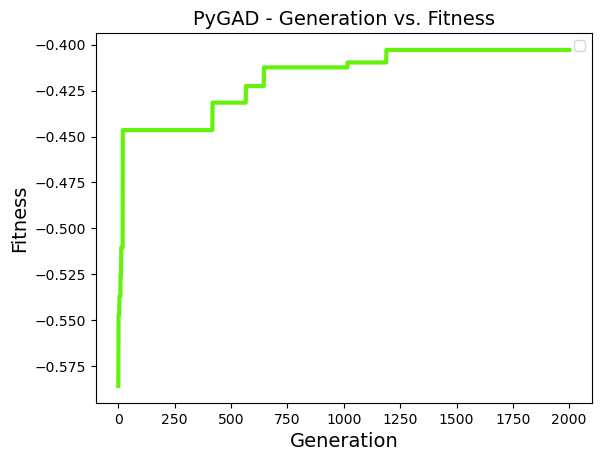

Best solution: [21. 23. 18. 41. 24. 39. 36. 13.  6.  3. 20. 29. 11. 34. 30. 42. 11.  6.
  5. 25. 24. 34. 14. 34. 20. 21. 39.  5.  6. 31. 12. 39. 39. 22. 25. 26.
 19. 14. 15. 26.  0. 40. 19. 36.  0. 14. 17. 38. 33. 20. 41. 38.  6. 23.
 20. 18. 16. 10. 29. 10. 22. 36. 17. 36. 27.  8. 37. 34. 32. 10. 41. 33.
 11. 11. 34. 11. 37.  6. 14. 31. 41. 38. 23. 28.  5. 27. 42. 35.  3. 29.
 41.  1. 21. 35. 25. 26.  5.  3. 35.  2.  0. 12. 38.  2.  7. 40.  9. 34.
 20. 34. 21.  4. 14. 30. 14. 16. 24. 11. 29. 22. 24. 22. 13. 20.  6. 38.
 27. 29. 34. 19. 25. 10. 15. 24. 42. 24. 19. 38.  2. 15. 32.  3.  2. 26.
 15. 16. 21.  7. 33. 41. 39. 17. 20. 29. 41. 33.  6.  3.  9. 40. 15. 32.
 21. 19.  1. 12. 10.  5. 13. 29. 33. 25. 12. 21. 40. 19. 21. 25. 15. 36.
 40. 21.  6. 15. 40.  9. 26. 24. 12. 31. 30. 27. 26.  8. 42. 41. 29.  0.
 11. 11. 40. 35. 29. 35. 16. 28. 31.  5. 25. 21.  0. 32. 17.  2. 29. 38.
 41.  2. 41. 34. 38.  5. 14. 15. 24.  7. 20. 16. 19. 18. 27. 13. 17.  2.
 36. 11. 26. 22. 32. 22. 29.  6. 22.

Generation = 1868
Fitness    = -4379.79
Generation = 1869
Fitness    = -4379.79
Generation = 1870
Fitness    = -4379.79
Generation = 1871
Fitness    = -4379.79
Generation = 1872
Fitness    = -4379.79
Generation = 1873
Fitness    = -4379.79
Generation = 1874
Fitness    = -4379.79
Generation = 1875
Fitness    = -4379.79
Generation = 1876
Fitness    = -4379.79
Generation = 1877
Fitness    = -4379.79
Generation = 1878
Fitness    = -4379.79
Generation = 1879
Fitness    = -4379.79
Generation = 1880
Fitness    = -4379.79
Generation = 1881
Fitness    = -4379.79
Generation = 1882
Fitness    = -4379.79
Generation = 1883
Fitness    = -4379.79
Generation = 1884
Fitness    = -4379.79
Generation = 1885
Fitness    = -4379.79
Generation = 1886
Fitness    = -4379.79
Generation = 1887
Fitness    = -4379.79
Generation = 1888
Fitness    = -4379.79
Generation = 1889
Fitness    = -4379.79
Generation = 1890
Fitness    = -4379.79
Generation = 1891
Fitness    = -4379.79
Generation = 1892
Fitness    = -4379.79


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Generation = 2000
Fitness    = -4379.79


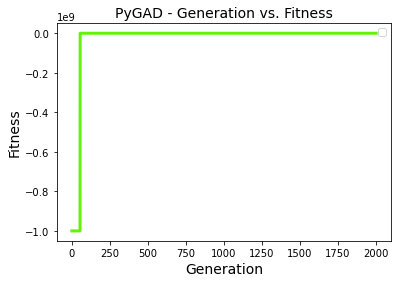

Best solution: [50. 68.  2. ... 46. 17. 66.] with fitness: -4379.79


In [21]:
num_genes = 800
g_space = []
for i in range(43):
    g_space.append(i)

ga_instance = pygad.GA(
    num_generations = 2000,
    # number of population
    sol_per_pop = 400,
    # number of gen in each chromosome
    num_genes = num_genes,
    # gens
    gene_space = g_space,
    # number of crossover in each generation
    num_parents_mating = 380,
    crossover_type = "two_points",
    # selection
    parent_selection_type = "tournament",
    keep_elitism = 100,
    
    mutation_type = "swap",
    mutation_percent_genes = 10,
    
    random_seed = 45321569,
    fitness_func = fitness_function,
    on_generation = on_generation
)

ga_instance.run()
ga_instance.plot_fitness()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best solution: {solution} with fitness: {solution_fitness}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


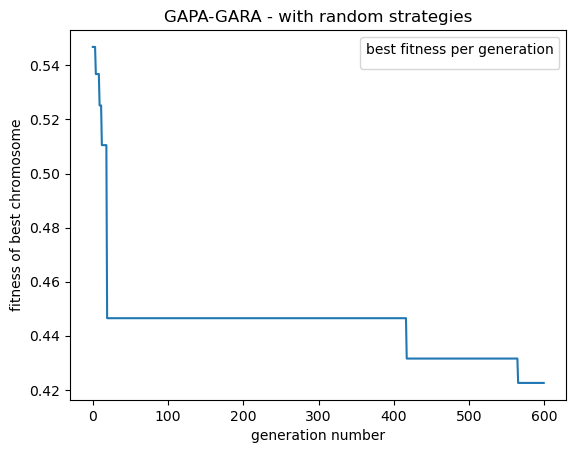

In [22]:
# 
b = []
c = []
for i in range(600):
    b.append(i)
    c.append(-a[i])


plt.legend(title = "best fitness per generation")
plt.title("GAPA-GARA - with random strategies")
plt.xlabel("generation number")
plt.ylabel("fitness of best chromosome")
plt.plot(b, c, '-')
plt.show()